In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

plt.style.use('fivethirtyeight')
sns.set(color_codes=True)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [4]:
print("Number of records in train data {}".format(train.shape[0]))
print("Number of records in test data {}".format(test.shape[0]))

Number of records in train data 245725
Number of records in test data 105312


In [6]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

<h2>1. Exploratory Data Analysis</h2>

<h3>1.1. Missing Values</h3>

* In train dataset, **`Credit_Product`** there is **11.93 %** missing data points.
* In test dataset, **`Credit_Product`** there is **11.89 %** missing data points.

In [7]:
train.isnull().mean()*100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

In [8]:
test.isnull().mean()*100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.890383
Avg_Account_Balance     0.000000
Is_Active               0.000000
dtype: float64

<h3>1.2. Target Variable Distribution</h3>

The target variable **`Is_Lead`** has imbalance between the two classes **0** (**76.27%**) and **1** (**23.72**). We need to use over-sampling techniques like **`SMOTE`** to balance the dataset.

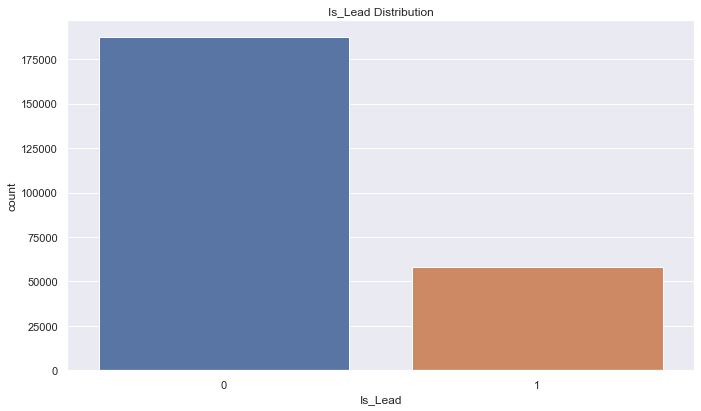

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(x = "Is_Lead", data=train)
plt.title("Is_Lead Distribution")
plt.show()

In [10]:
train['Is_Lead'].value_counts(normalize=True)*100

0    76.279174
1    23.720826
Name: Is_Lead, dtype: float64

<h3>1.3. Numerical Features Distribution</h3>

The following charts on Numerical Features provide us witth the following insights :
* The Age distribution in train dataset and test dataset is almost similar
* Avg_Account_Balance feature is skewed.
* Customers aged between 40-60 have greater interest in credit cards. 
* Customers in their 20s and 30s and less interested
* The Avg_Account_Balance, Vintage distribution in train dataset and test dataset is almost similar. 

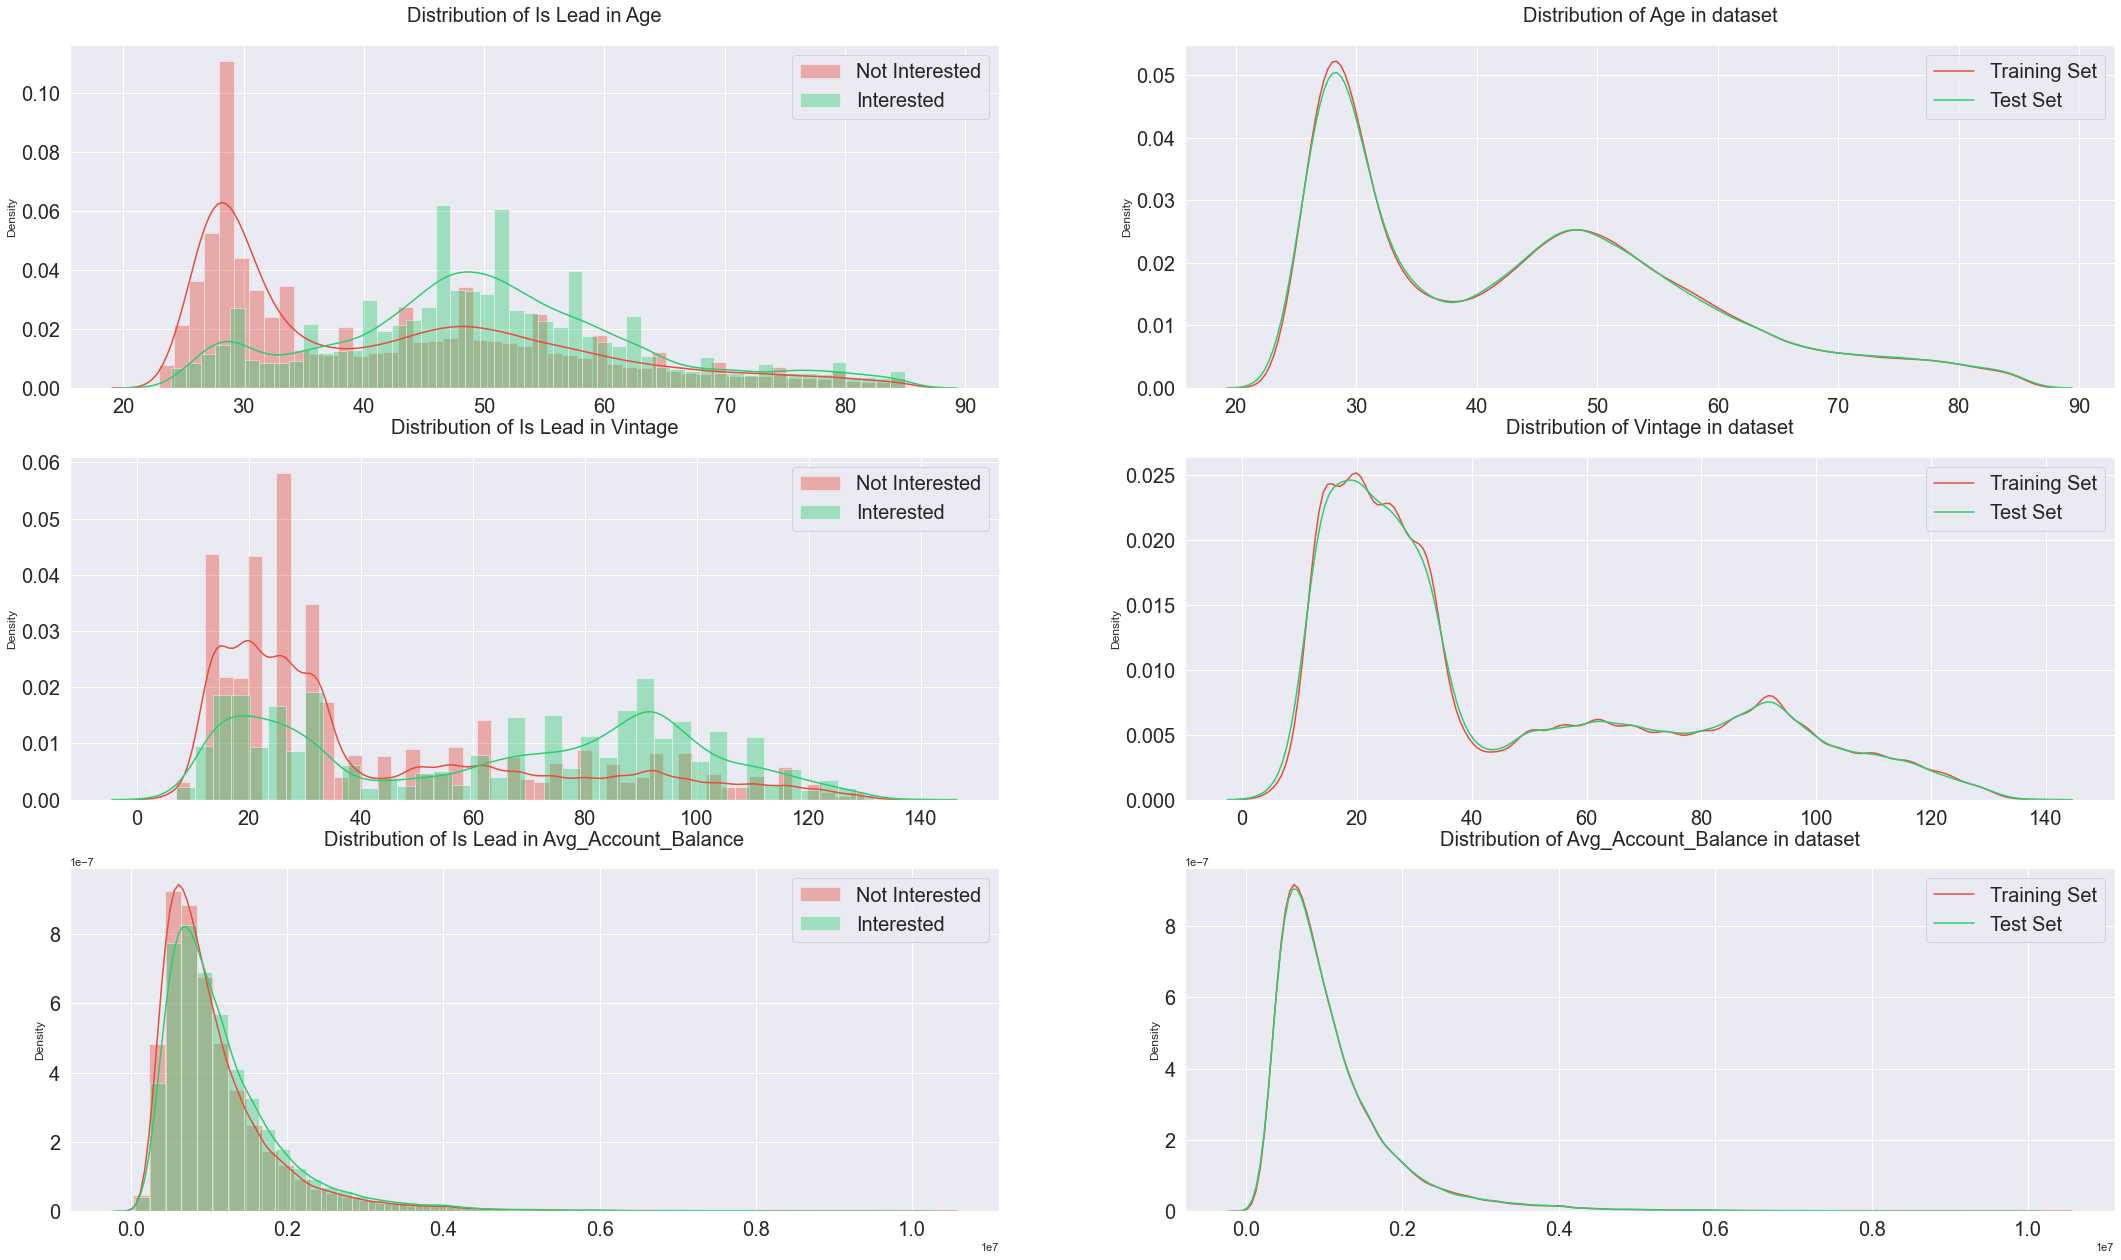

In [11]:
numerical_feat = [feat for feat in train.columns if (train[feat].dtypes=='int64') & ~(feat=='Is_Lead')]
interested = train['Is_Lead'] == 1

fig, axs = plt.subplots(ncols=2, nrows=len(numerical_feat), figsize=(20,20))
plt.subplots_adjust(right=1.5)

for i , col in enumerate(numerical_feat) :
    
    # Distribution of Is Lead in feature
    sns.distplot(train[~interested][col], label='Not Interested', hist=True, color='#e74c3c', ax=axs[i][0])
    sns.distplot(train[interested][col], label='Interested', hist=True, color='#2ecc71', ax=axs[i][0])
    axs[i][0].set_xlabel('')
    axs[i][0].tick_params(axis='x', labelsize=20)
    axs[i][0].tick_params(axis='y', labelsize=20)
    axs[i][0].legend(loc='upper right', prop={'size': 20})
    axs[i][0].set_title('Distribution of Is Lead in {}'.format(col), size=20, y=1.05)
    
    # Distribution of feature in dataset
    sns.distplot(train[col], label='Training Set', hist=False, color='#e74c3c', ax=axs[i][1])
    sns.distplot(test[col], label='Test Set', hist=False, color='#2ecc71', ax=axs[i][1])
    axs[i][1].set_xlabel('')
    axs[i][1].tick_params(axis='x', labelsize=20)
    axs[i][1].tick_params(axis='y', labelsize=20)
    axs[i][1].legend(loc='upper right', prop={'size': 20})
    axs[i][1].set_title('Distribution of {} in dataset'.format(col), size=20, y=1.05)
        
plt.show()

In [12]:
for feat in numerical_feat :    
    print('{} feature has a skewness of {} and kurtosis of {} in train set'.format(feat, train[feat].skew().round(3)
                                                                      , train[feat].kurtosis().round(3)))
    print('{} feature has a skewness of {} and kurtosis of {} in test set'.format(feat, test[feat].skew().round(3)
                                                                      , test[feat].kurtosis().round(3)))
    print()

Age feature has a skewness of 0.619 and kurtosis of -0.441 in train set
Age feature has a skewness of 0.628 and kurtosis of -0.423 in test set

Vintage feature has a skewness of 0.79 and kurtosis of -0.697 in train set
Vintage feature has a skewness of 0.791 and kurtosis of -0.689 in test set

Avg_Account_Balance feature has a skewness of 2.969 and kurtosis of 14.305 in train set
Avg_Account_Balance feature has a skewness of 2.998 and kurtosis of 14.43 in test set



<h3>1.4. Categorical Features Distribution</h3>

The following charts on Categorical Features provide us witth the following insights :
* Salaried person are less likely to take up credit cards. Only among Entrepreneur the number of customers interested to take up credit cards is more
* Male customers are present more in the dataset than females.
* Customers who were active in last 3 months have slightly more interest in credit cards then other customers
* Number of Customers having credit products who are interested in Credit Card is more than those who donot have a Credit Product. 

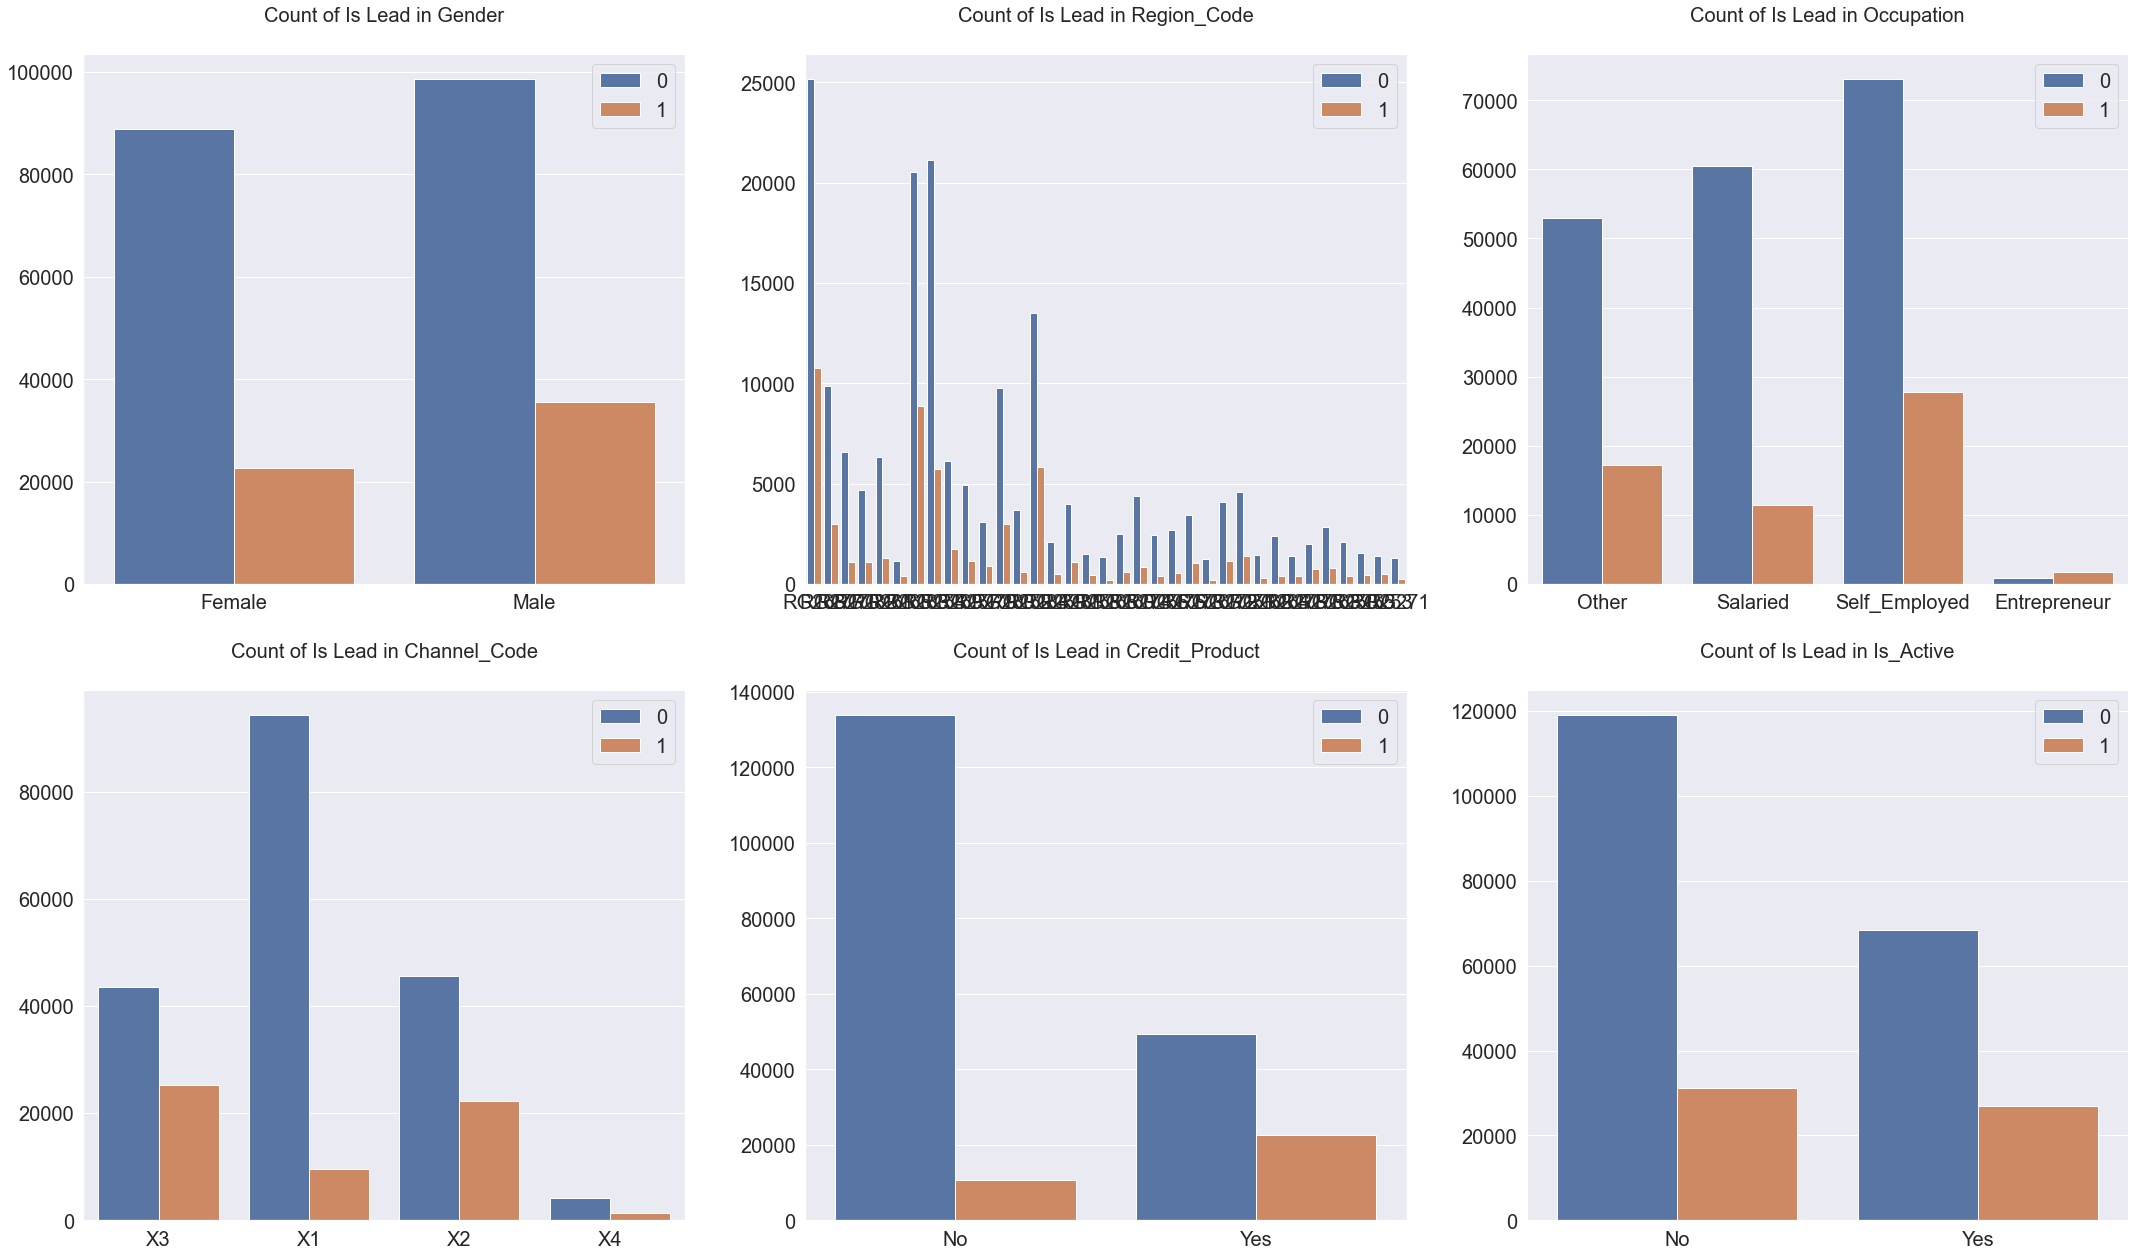

In [13]:
categorical_feat = [col for col in train.columns if (train[col].dtypes=='object') & (col!='ID')]

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,20))
plt.subplots_adjust(right=1.5)

for i , col in enumerate(categorical_feat) :
    plt.subplot(2, 3, i+1)
    # Distribution of Is Lead in feature
    sns.countplot(x= col, data = train, hue='Is_Lead')
    plt.xlabel('')
    plt.ylabel('')
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.legend(loc='upper right', prop={'size': 20})
    plt.title('Count of Is Lead in {}'.format(col), size=20, y=1.05)
        
plt.show()

<h3>1.5. Correlations</h3>

* **`Age`** and **`Vintage`** has highest correlation (__0.63__) in train dataset and (__0.62__) in test dataset.

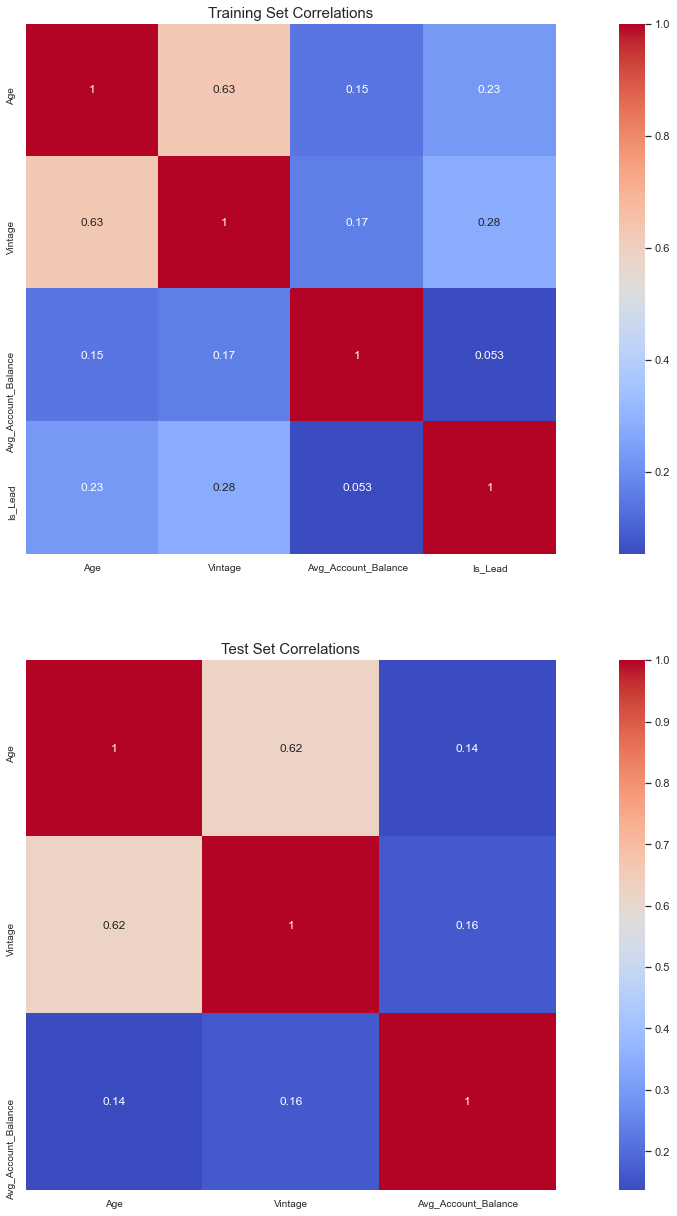

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(train.drop(['ID'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 12})
sns.heatmap(test.drop(['ID'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 12})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

<h3>1.6. Outliers</h3>

In the train dataset **`Avg_Account_Balance`** has outliers.

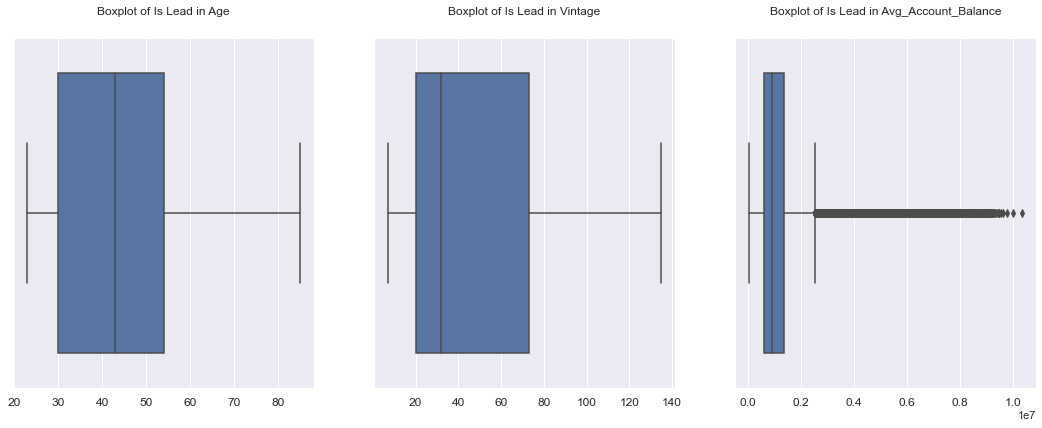

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10,6))
plt.subplots_adjust(right=1.5)

for i , col in enumerate(numerical_feat) :
    
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=col, data=train)
    plt.xlabel('')
    plt.ylabel('')
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    #plt.legend(loc='upper right', prop={'size': 20})
    plt.title('Boxplot of Is Lead in {}'.format(col), size=12, y=1.05)
        
plt.show()

<b><i>Data Insights</i></b>

* Age 40-65, salaried are interested to buy credit card. Most of the Entrepreneurs also seem interested but not all.
* Customers who already have any credit product are likely to buy credit card.
* Salaried people with Channel code X1 haven't shown much interest in the past.
* There are only 2 Entrepreneurs who don't have any credit product.
* 66% of total Customers falling in Entrepreneural category in Occupation have shown interest in the past followed by 27.6% Self Employed, 24.5% in Others category and 16% Salaried.

In [21]:
total_customers_by_occu = train.groupby(['Occupation'])['ID'].count().reset_index()
total_customers_by_occu.rename(columns={'ID' : 'Total Customers'}, inplace=True)
num_customers_by_occupation = train.groupby(['Is_Lead', 'Occupation'])['ID'].count().reset_index()
num_customers_by_occupation = pd.merge(num_customers_by_occupation, total_customers_by_occu , how='inner', on='Occupation')
num_customers_by_occupation['% of Total'] = round((num_customers_by_occupation['ID'] / num_customers_by_occupation['Total Customers']) * 100, 1)
num_customers_by_occupation = num_customers_by_occupation.sort_values(by=['Is_Lead', '% of Total'], ascending = [False, False])

num_customers_by_occupation.drop(columns=['ID', 'Total Customers'], inplace=True, axis=1)
df = pd.crosstab(num_customers_by_occupation['Occupation'], num_customers_by_occupation['Is_Lead'], values=num_customers_by_occupation['% of Total'], aggfunc=sum)

In [27]:
# Function to plot stacked bars with annotations

def plot_stack_bars(df, title_,  y_label, size_=(20,10), rot_=0, legend_='upper_right'):
    
    ax = df.plot(kind='bar', stacked=True, figsize=size_, rot=rot_, title=title_)
    
    annotate_plot(ax, textsize=15)
    
    plt.legend([0, 1], loc=legend_)
    plt.ylabel(y_label)
    plt.show()

def annotate_plot(ax, pad=1, colour='white', textsize=14):
    
    for i in ax.patches:
        
        val = str(round(i.get_height(),1))
        
        if val=='0.0':
            continue
        ax.annotate(val , ((i.get_x()+i.get_width()/2)*pad-0.05, (i.get_y()+i.get_height()/2)*pad), color=colour, size=textsize)

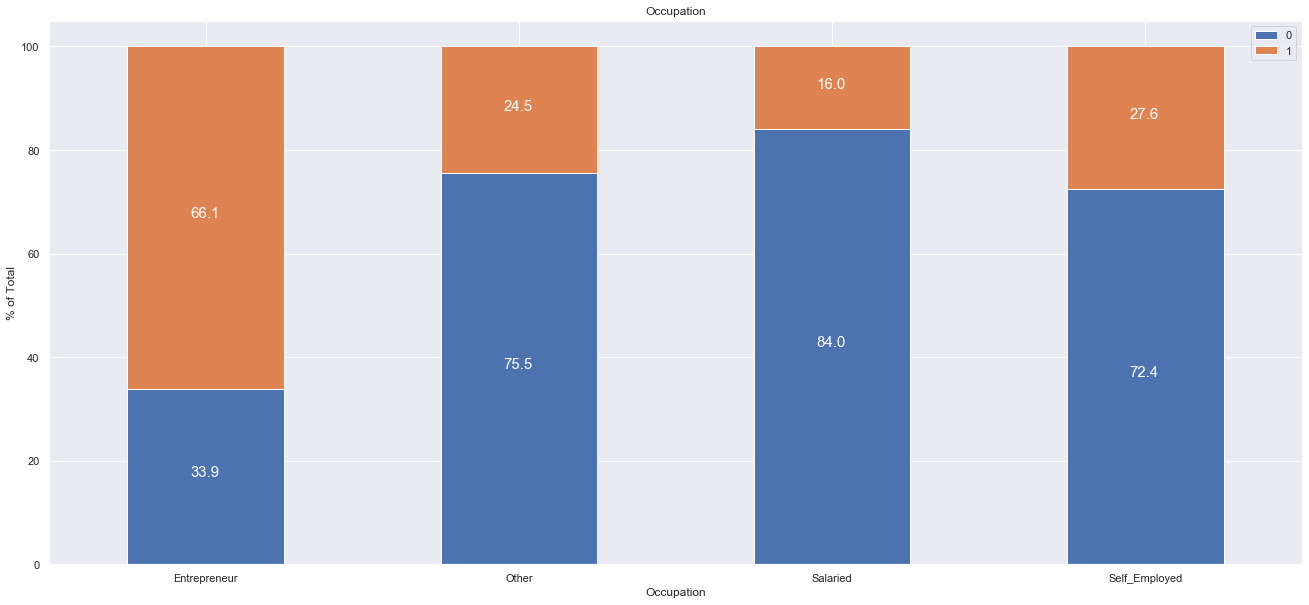

In [28]:
plot_stack_bars(df, 'Occupation', '% of Total', rot_=0)

<h2>2. Data Cleaning</h2>

<h3>2.1. Missing Value of Credit_Product</h3>

The missing values in the feature **`Credit_Product`** will be imputed with **`No_Info`**

In [16]:
# filling null values with No_Info

train['Credit_Product'] = train['Credit_Product'].fillna("No_Info")
test['Credit_Product'] = test['Credit_Product'].fillna("No_Info")

In [17]:
train['Credit_Product'].value_counts()

No         144357
Yes         72043
No_Info     29325
Name: Credit_Product, dtype: int64

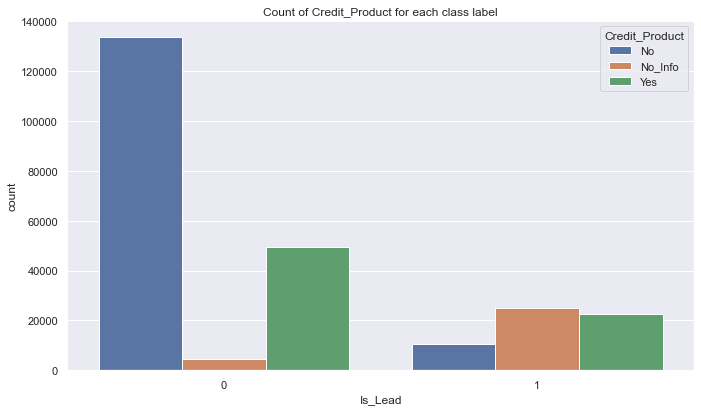

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(x = "Is_Lead", data = train, hue = "Credit_Product")
plt.title("Count of Credit_Product for each class label")
plt.show()

Among all customers, Customers having a Credit Product have a greater chance of having a Credit Card.  

<h2>3. Feature Engineering</h2>

<h3>3.1. One Hot Encoding of Categorical Features</h3>

In [19]:
categorical_columns = ["Gender","Region_Code","Occupation","Channel_Code","Credit_Product","Is_Active"]

# train = pd.concat([train, pd.get_dummies(train, columns=categorical_columns)], axis=1)
# test = pd.concat([test, pd.get_dummies(test, columns=categorical_columns)], axis=1)

train = pd.concat([train, pd.get_dummies(train[categorical_columns])], axis=1)
test = pd.concat([test, pd.get_dummies(test[categorical_columns])], axis=1)

In [20]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead', 'Gender_Female', 'Gender_Male', 'Region_Code_RG250',
       'Region_Code_RG251', 'Region_Code_RG252', 'Region_Code_RG253',
       'Region_Code_RG254', 'Region_Code_RG255', 'Region_Code_RG256',
       'Region_Code_RG257', 'Region_Code_RG258', 'Region_Code_RG259',
       'Region_Code_RG260', 'Region_Code_RG261', 'Region_Code_RG262',
       'Region_Code_RG263', 'Region_Code_RG264', 'Region_Code_RG265',
       'Region_Code_RG266', 'Region_Code_RG267', 'Region_Code_RG268',
       'Region_Code_RG269', 'Region_Code_RG270', 'Region_Code_RG271',
       'Region_Code_RG272', 'Region_Code_RG273', 'Region_Code_RG274',
       'Region_Code_RG275', 'Region_Code_RG276', 'Region_Code_RG277',
       'Region_Code_RG278', 'Region_Code_RG279', 'Region_Code_RG280',
       'Region_Code_RG281', 'Region_Code_RG282', 'Region_Code_RG283',
       'Regi

__Dropping Irrelevent Columns__

In [21]:
train.drop(columns=categorical_columns, inplace=True)
test.drop(columns = categorical_columns, inplace = True)

In [22]:
train.head()

,ID,Age,Vintage,Avg_Account_Balance,Is_Lead,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,...,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_No,Credit_Product_No_Info,Credit_Product_Yes,Is_Active_No,Is_Active_Yes
0,NNVBBKZB,73,43,1045696,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,IDD62UNG,30,32,581988,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,HD3DSEMC,56,26,1484315,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
3,BF3NC7KV,34,19,470454,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,TEASRWXV,30,33,886787,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [23]:
# Dropping 'ID' column from train

train.drop(columns=['ID'], inplace=True)

In [24]:
df_test = test.copy()

In [25]:
# Dropping 'ID' column from test dataset

df_test.drop(columns=['ID'], inplace=True)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   Age                       245725 non-null  int64
 1   Vintage                   245725 non-null  int64
 2   Avg_Account_Balance       245725 non-null  int64
 3   Is_Lead                   245725 non-null  int64
 4   Gender_Female             245725 non-null  uint8
 5   Gender_Male               245725 non-null  uint8
 6   Region_Code_RG250         245725 non-null  uint8
 7   Region_Code_RG251         245725 non-null  uint8
 8   Region_Code_RG252         245725 non-null  uint8
 9   Region_Code_RG253         245725 non-null  uint8
 10  Region_Code_RG254         245725 non-null  uint8
 11  Region_Code_RG255         245725 non-null  uint8
 12  Region_Code_RG256         245725 non-null  uint8
 13  Region_Code_RG257         245725 non-null  uint8
 14  Region_Code_RG258   

In [27]:
# Spliting into X (features) and Y (Target Variable)

X = train.drop(columns=['Is_Lead'])
y = train[['Is_Lead']]

In [28]:
y.value_counts(normalize=True)

Is_Lead
0          0.762792
1          0.237208
dtype: float64

There is a class imbalance observed in the target feature. About **76.27%** customers are not interested in credit card, and about **23.72%** are interested in credit card. To address this issue Oversampling techniques like **SMOTE** is needed in order to balance the class imbalance.

<h2>4. Oversampling (Handling Class Imbalance)</h2>

In [29]:
smote = SMOTE(random_state=42, n_jobs=-1)
X_train_smote, y_train_smote = smote.fit_resample(X,y)
X_train_smote.shape, y_train_smote.shape, y_train_smote.value_counts()

((374874, 53),
 (374874, 1),
 Is_Lead
 0          187437
 1          187437
 dtype: int64)

<h2>5. Modelling</h2>

* For Modelling both Light GBM and Xgboost model is used. 
* The dimensionality of data is low. 
* For combining the predictions made by XGBoost and Light GBM, stacking is used

<h3> 5.1. Light GBM Model </h3>

In [30]:
param_dist = {"n_estimators":sp_randint(40,100),
              "colsample_bytree":np.array([0.5,0.6,0.7,0.8,0.9,1]),
              "subsample":np.array([0.5,0.6,0.7,0.8,0.9,1]),
              "reg_lambda":np.array([1e-5,1e-4,1e-3,1e-2,0.1,1,10,100]),
              "reg_alpha":np.array([1e-5,1e-4,1e-3,1e-2,0.1,1,10,100]),
              "min_child_samples": sp_randint(25,65),
                "max_depth": sp_randint(1,20)}

clf_lgbm = LGBMClassifier(boosting_type = "gbdt",n_jobs =-1,random_state = 10)

# Randomized Search CV for finding the best parameters under roc_auc scoring

lgbm_cv = RandomizedSearchCV(clf_lgbm, param_distributions=param_dist,
                                   n_iter=20,cv=10,scoring='roc_auc',random_state=42,verbose=1)

lgbm_cv.fit(X_train_smote,y_train_smote)

print('mean test scores',lgbm_cv.cv_results_['mean_test_score'])

Fitting 10 folds for each of 20 candidates, totalling 200 fits
mean test scores [0.95900141 0.95913723 0.95260851 0.93910885 0.95905745 0.95965737
 0.95652856 0.95819661 0.94823886 0.9589766  0.95277563 0.95965053
 0.95917193 0.95889394 0.95850546 0.9338523  0.95867958 0.95685596
 0.93381059 0.95583902]


In [31]:
print('The best parameters {}'.format(lgbm_cv.best_params_))

The best parameters {'colsample_bytree': 0.8, 'max_depth': 16, 'min_child_samples': 39, 'n_estimators': 86, 'reg_alpha': 1.0, 'reg_lambda': 0.001, 'subsample': 0.8}


In [32]:
lgb_clf_model = LGBMClassifier(colsample_bytree=0.8, max_depth=16, min_child_samples=39,
               n_estimators=86, random_state=10, reg_alpha=1.0,
               reg_lambda=0.001, subsample=0.8)

lgb_clf_model.fit(X_train_smote,y_train_smote)

proba = lgb_clf_model.predict_proba(X)[:,1]

train_score = roc_auc_score(y,proba)

cv_score = cross_val_score(lgb_clf_model,X,y,scoring="roc_auc",verbose=2,cv =5).mean()

print('The Mean CV Score : ',cv_score)
print('Train Score : ',train_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.0s
The Mean CV Score :  0.874121947663389
Train Score :  0.8767263158367958


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s finished


In [33]:
# lgbm_pred_y = lgb_clf_model.predict_proba(df_test)[:,1]

# lgbm_predictions = pd.DataFrame()
# lgbm_predictions["ID"] = test["ID"]
# lgbm_predictions["Is_Lead"] = lgbm_pred_y

# # Saving to a csv file....

# lgbm_predictions.to_csv("Light_GBM_predictions.csv", index = False)

__Feature Importance for Light Gradient Boosting Model__

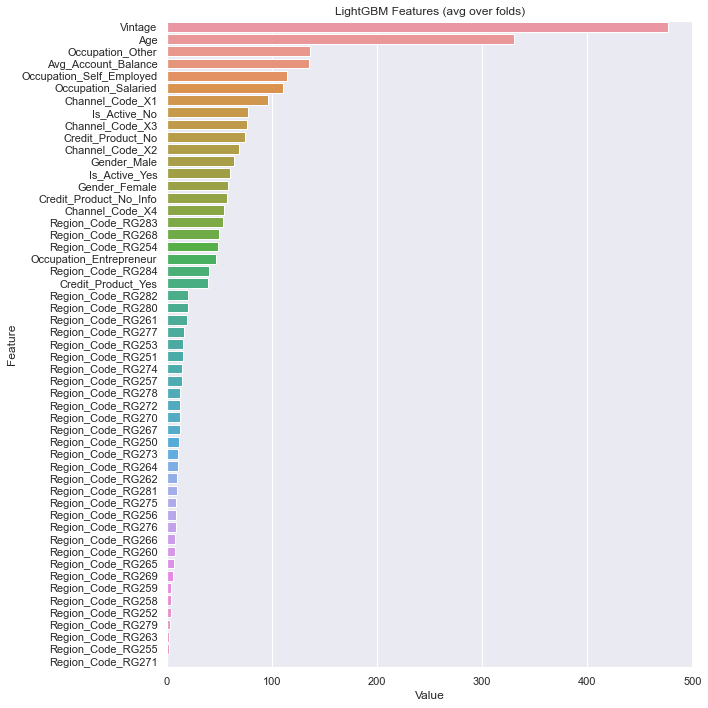

In [34]:
feature_imp = pd.DataFrame(sorted(zip(lgb_clf_model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

<h3> 5.2. XGBoost Model </h3>

In [35]:
# param_dist = {"n_estimators":sp_randint(40,100),
#               "colsample_bytree":np.array([0.5,0.6,0.7,0.8,0.9,1]),
#               "subsample":np.array([0.5,0.6,0.7,0.8,0.9,1]),
#               "reg_lambda":np.array([1e-5,1e-4,1e-3,1e-2,0.1,1,10,100]),
#               "reg_alpha":np.array([1e-5,1e-4,1e-3,1e-2,0.1,1,10,100]),
#               "min_child_samples": sp_randint(25,65),
#                 "max_depth": sp_randint(1,20)}

# clf_xgb_model = XGBClassifier(boosting_type = "gbdt",n_jobs =-1,random_state = 0,verbosity =0,scale_pos_weight = 3.2158)

# # Randomized Search CV for finding the best parameters under roc_auc scoring

# xgb_random_cv_model = RandomizedSearchCV(clf_xgb_model, param_distributions=param_dist,
#                                    n_iter=20,cv=5,scoring='roc_auc',random_state=42,verbose=1)

# xgb_random_cv_model.fit(X_train_smote,y_train_smote)

# # Mean CV Test Scores
# print('mean CV test scores',xgb_random_cv_model.cv_results_['mean_test_score'])

In [36]:
#xgb_random_cv_model.best_estimator_

In [37]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_samples=52,
              min_child_weight=1 ,monotone_constraints='()',
              n_estimators=46, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=1e-05, reg_lambda=100.0, scale_pos_weight=3.2158,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=0)
xgb_model.fit(X_train_smote,y_train_smote)
proba = xgb_model.predict_proba(X)[:,1]
train_score = roc_auc_score(y,proba)
cv_score = cross_val_score(xgb_model,X,y,scoring="roc_auc",verbose=2,cv =5).mean()
print(cv_score)
print(train_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   5.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] END .................................................... total time=   6.8s
[CV] END .................................................... total time=   6.9s
[CV] END .................................................... total time=   6.0s
[CV] END .................................................... total time=   6.7s
0.8735201481668635
0.8799996011762707


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.8s finished


In [38]:
# xgbm_pred_y = xgb_model.predict_proba(df_test)[:,1]

# xgbm_predictions = pd.DataFrame()
# xgbm_predictions["ID"] = test["ID"]
# xgbm_predictions["Is_Lead"] = xgbm_pred_y

# # Saving to a csv file....

# xgbm_predictions.to_csv("Xgboost_predictions.csv", index = False)

__Feature Importance for Xgboost__

In [39]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

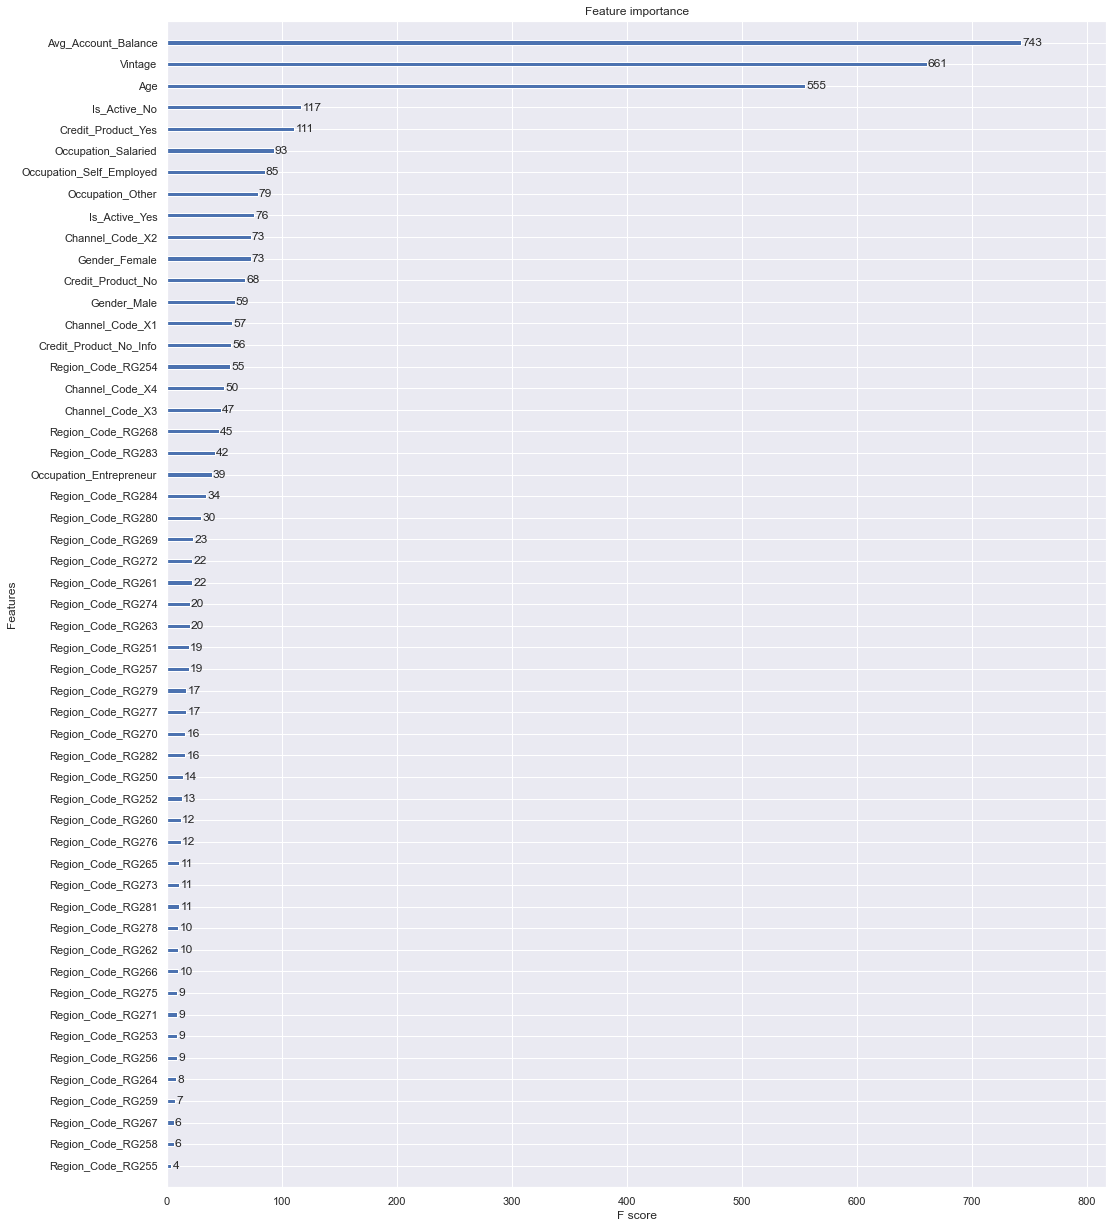

In [40]:
fig, ax = plt.subplots(figsize=(15,20))
plot_importance(xgb_model , ax=ax)

<h3>5.3. Stacking of Xgboost and Light GBM Classifier </h3>

In [53]:
# Xgboost Classifier

xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_samples=52,
              min_child_weight=1 ,monotone_constraints='()',
              n_estimators=46, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=1e-05, reg_lambda=100.0, scale_pos_weight=3.2158,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=0)
xgb_model.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_samples=52,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=46, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=1e-05, reg_lambda=100.0, scale_pos_weight=3.2158,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [54]:
# Light Gradient Boosting Classifier

lgbm_model  = LGBMClassifier(colsample_bytree=0.8, max_depth=16, min_child_samples=39,
               n_estimators=86, random_state=10, reg_alpha=1.0,
               reg_lambda=0.001, subsample=0.8)
lgbm_model.fit(X,y)

LGBMClassifier(colsample_bytree=0.8, max_depth=16, min_child_samples=39,
               n_estimators=86, random_state=10, reg_alpha=1.0,
               reg_lambda=0.001, subsample=0.8)

In [43]:
# Stacking Classifier

alpha = [1e-5, 0.01,0.001,1] 
for i in alpha:
    lr = LogisticRegression(C = i )
    
    stack_clf = StackingClassifier([lgbm_model,xgb_model], meta_classifier=lr, use_probas=True )
    stack_clf.fit(X,y)
    
    train_proba = stack_clf.predict_proba(X)[:,1]
    train_score = roc_auc_score(y,train_proba)
    
    cv_score = cross_val_score(stack_clf, X,y,scoring="roc_auc",verbose=0,cv =5).mean()
    
    print("Stacking classifier for alpha = %f, train score is %f and cv_score is %f"%(i, train_score, cv_score))

Stacking classifier for alpha = 0.000010, train score is 0.881475 and cv_score is 0.874063
Stacking classifier for alpha = 0.010000, train score is 0.881528 and cv_score is 0.874029
Stacking classifier for alpha = 0.001000, train score is 0.881490 and cv_score is 0.874055
Stacking classifier for alpha = 1.000000, train score is 0.881553 and cv_score is 0.874006


In [55]:
# Using the Stacking Classifier for the best value of alpha

lr = LogisticRegression(C =0.0001)
stack_clf =StackingClassifier([lgbm_model,xgb_model], meta_classifier=lr, use_probas=True )
stack_clf.fit(X,y)
train_proba = stack_clf.predict_proba(X)[:,1]
train_score = roc_auc_score(y,train_proba)
cv_score = cross_val_score(stack_clf, X,y,scoring="roc_auc",verbose=0,cv =5).mean()
print("Stacking classifier for alpha = %f, train score is %f and cv_score is %f"%(i, train_score, cv_score))

Stacking classifier for alpha = 1.000000, train score is 0.881475 and cv_score is 0.874063


In [56]:
# Finding the probabilistic lead prediction using the Stacking Classifier

stack_clf_pred = stack_clf.predict_proba(df_test)[:,1]

stack_clf_predictions = pd.DataFrame()
stack_clf_predictions["ID"] = test["ID"]
stack_clf_predictions["Is_Lead"] = stack_clf_pred

In [57]:
stack_clf_predictions.to_csv("Stacking_XGB_LightGBM_predictions.csv", index = False)